In [194]:
import pandas as pd
import glob
import os
import wfdb
# Define o padrão para os arquivos CSV

path = r'D:\Projeto_Tese_mestrado\02_Dataset\dados_ECG\Holter_ECG\P0*'

#path = r'E:/Repositorio_Git/zzz-projeto_final/dados/ca-*.csv'


# Usando glob para pegar todos os arquivos que seguem o padrão
arquivos = glob.glob(path)
#arquivos_path_holter = glob.glob(path_holter)
arquivos = [os.path.splitext(arquivo)[0] for arquivo in arquivos] # tirando as a extensões





lista_sem_duplicatas = pd.Series(arquivos).unique().tolist() # removando duplicadas


record = wfdb.rdrecord(lista_sem_duplicatas[0])


p_signal = record.p_signal



sinal_x = p_signal[:,0]
sinal_y = p_signal[:,1]
sinal_z = p_signal[:,2]

In [2]:
# necessario 
#!pip install ts2vg

In [195]:
amostra_x = sinal_x[720000:724000]

In [196]:
len(amostra_x)

4000

In [197]:
import neurokit2 as nk

# 1. ECG cru (simulado ou real)

sampling_rate = 200

In [198]:
amostra=  amostra_x.copy()

In [199]:
signals, _ = nk.ecg_process(amostra, sampling_rate=200, method="neurokit")

In [49]:
signals.head()

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,-0.16,-0.027171,120.992761,0.178326,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,-0.12,-0.023411,120.992761,0.178326,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,-0.15,-0.025277,120.992761,0.178326,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,-0.18,-0.028395,120.992761,0.178326,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,-0.14,-0.030891,120.992761,0.178326,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


In [200]:
ecg = signals["ECG_Clean"]

In [201]:
# Observações importantes:
# A ordem dos filtros importa, especialmente para passa-alta e passa-baixa.

# Verifique sempre a frequência de amostragem do seu ECG para ajustar os filtros corretamente.

# Use filtfilt() para evitar distorções de fase (zero-phase filtering).

# Se você tiver dados de dispositivos portáteis, como wearables, o ruído é maior — então esses filtros combinados são ainda mais úteis.
from scipy.signal import butter, filtfilt, iirnotch
import numpy as np

# Filtro passa-alta: remove variações lentas (ex: baseline wander)
def filtro_passa_alta(signal, fs, cutoff=0.5, ordem=5):
    """
    Aplica filtro passa-alta para remover variações de baixa frequência,
    como o desvio da linha de base causado pela respiração.
    
    Parâmetros:
    - signal: vetor com o sinal ECG
    - fs: frequência de amostragem (Hz)
    - cutoff: frequência de corte (Hz)
    - ordem: ordem do filtro
    
    Retorna:
    - Sinal filtrado com o filtro passa-alta
    """
    nyq = 0.5 * fs  # Frequência de Nyquist
    b, a = butter(ordem, cutoff / nyq, btype='high')  # Cria filtro de Butterworth passa-alta
    return filtfilt(b, a, signal)  # Aplica filtro com zero defasagem (filtfilt)

# Filtro notch: remove ruído da rede elétrica (60Hz ou 50Hz)
def filtro_notch(signal, fs, freq=50, Q=30):
    """
    Aplica filtro notch (rejeição de banda) para eliminar interferência da rede elétrica.
    
    Parâmetros:
    - signal: vetor com o sinal ECG
    - fs: frequência de amostragem (Hz)
    - freq: frequência a ser removida (normalmente 60Hz ou 50Hz)
    - Q: fator de qualidade (define a largura da banda rejeitada)
    
    Retorna:
    - Sinal filtrado com o filtro notch
    """
    nyq = 0.5 * fs  # Frequência de Nyquist
    w0 = freq / nyq  # Frequência normalizada
    b, a = iirnotch(w0, Q)  # Cria filtro notch
    return filtfilt(b, a, signal)  # Aplica filtro com zero defasagem

# Filtro passa-baixa: remove ruído de alta frequência (ex: EMG)
def filtro_passa_baixa(signal, fs, cutoff=45, ordem=5):
    """
    Aplica filtro passa-baixa para eliminar ruídos de alta frequência,
    como ruído muscular e de equipamentos.
    
    Parâmetros:
    - signal: vetor com o sinal ECG
    - fs: frequência de amostragem (Hz)
    - cutoff: frequência de corte superior (Hz)
    - ordem: ordem do filtro
    
    Retorna:
    - Sinal filtrado com o filtro passa-baixa
    """
    nyq = 0.5 * fs
    b, a = butter(ordem, cutoff / nyq, btype='low')  # Cria filtro de Butterworth passa-baixa
    return filtfilt(b, a, signal)  # Aplica filtro com zero defasagem

# Pipeline completo de filtros: aplica os três filtros em sequência
def pipeline_filtros(ecg, fs):
    """
    Aplica um pipeline de pré-processamento ao sinal ECG:
    1. Remove variações lentas (baseline)
    2. Remove ruído da rede elétrica (60Hz)
    3. Remove ruído de alta frequência (EMG, eletrônicos)

    Parâmetros:
    - ecg: vetor com o sinal ECG original
    - fs: frequência de amostragem (Hz)

    Retorna:
    - Sinal ECG filtrado
    """
    ecg = filtro_passa_alta(ecg, fs, cutoff=0.5)
    ecg = filtro_notch(ecg, fs, freq=60)
    ecg = filtro_passa_baixa(ecg, fs, cutoff=45)
    return ecg



In [202]:
teste1 = pipeline_filtros(amostra, fs=200)

In [203]:
teste2 = ecg

In [204]:
teste2[:5].values

array([-0.0271709 , -0.02341096, -0.02527719, -0.0283954 , -0.03089104])

In [205]:
teste1[:5]

array([-0.02423727, -0.00882041, -0.01303984, -0.03160362, -0.04303496])

In [206]:
def filtro_passa_alta(signal, fs, cutoff=0.5, ordem=5):
    nyq = 0.5 * fs
    b, a = butter(ordem, cutoff / nyq, btype='high')
    return filtfilt(b, a, signal)

def filtro_notch(signal, fs, freq=50, Q=30):
    nyq = 0.5 * fs
    w0 = freq / nyq
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, signal)

def filtro_neurokit_like(ecg, fs):
    # Primeiro aplica filtro passa-alta igual ao do NeuroKit
    ecg = filtro_passa_alta(ecg, fs, cutoff=0.5, ordem=5)
    
    # Depois remove ruído da rede (padrão 50Hz)
    ecg = filtro_notch(ecg, fs, freq=60)
    
    return ecg


In [207]:
teste3 = filtro_neurokit_like(amostra, fs=200)

In [208]:
def filtro_neurokit_igual(signal, fs):
    # Remove a média do sinal (centragem)
    signal = signal - np.mean(signal)
    
    # Passa-alta Butterworth
    b, a = butter(5, 0.5 / (0.5 * fs), btype="high")
    signal = filtfilt(b, a, signal)
    
    # Filtro Notch 50Hz (como no NeuroKit)
    b, a = iirnotch(60 / (0.5 * fs), Q=30)
    signal = filtfilt(b, a, signal)
    
    return signal


teste4 = filtro_neurokit_igual(amostra, fs=200)

In [235]:
ecg_filtrado = nk.signal_filter(
    signal=amostra,
    sampling_rate=200,
    lowcut=0.5,
    highcut=45,
    method="butterworth",
    order=5,
    powerline=50
)

In [210]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, bessel, firwin, filtfilt, iirnotch, savgol_filter, sosfiltfilt

def filtro_manual(signal, fs, lowcut=None, highcut=None, method='butterworth', ordem=2,
                  window_size=None, powerline=None, show=False):

    # Aplica filtro Notch para remover interferência da rede elétrica
    if powerline is not None:
        w0 = powerline / (fs / 2)
        b, a = iirnotch(w0, Q=30)
        signal = filtfilt(b, a, signal)

    # Define as bordas de corte normalizadas
    nyq = 0.5 * fs
    low = lowcut / nyq if lowcut else None
    high = highcut / nyq if highcut else None

    # Aplica filtro conforme método
    if method == "butterworth":
        sos = None
        if low and high:
            sos = butter(ordem, [low, high], btype='band', output='sos')
        elif low:
            sos = butter(ordem, low, btype='high', output='sos')
        elif high:
            sos = butter(ordem, high, btype='low', output='sos')
        if sos is not None:
            signal = sosfiltfilt(sos, signal)

    elif method == "butterworth_ba":
        if low and high:
            b, a = butter(ordem, [low, high], btype='band')
        elif low:
            b, a = butter(ordem, low, btype='high')
        elif high:
            b, a = butter(ordem, high, btype='low')
        signal = filtfilt(b, a, signal)

    elif method == "bessel":
        if low and high:
            b, a = bessel(ordem, [low, high], btype='band')
        elif low:
            b, a = bessel(ordem, low, btype='high')
        elif high:
            b, a = bessel(ordem, high, btype='low')
        signal = filtfilt(b, a, signal)

    elif method == "fir":
        if high and not low:
            b = firwin(numtaps=ordem * 2 + 1, cutoff=high, fs=fs)
        elif low and not high:
            b = firwin(numtaps=ordem * 2 + 1, cutoff=low, fs=fs, pass_zero=False)
        elif low and high:
            b = firwin(numtaps=ordem * 2 + 1, cutoff=[lowcut, highcut], fs=fs, pass_zero=False)
        else:
            raise ValueError("Você precisa definir 'lowcut' e/ou 'highcut' para usar FIR.")
        signal = filtfilt(b, [1], signal)

    elif method == "savgol":
        if window_size is None:
            window_size = int(fs / 10)
            if window_size % 2 == 0:
                window_size += 1
        signal = savgol_filter(signal, window_length=window_size, polyorder=ordem)

    # # Mostra o gráfico
    # if show:
    #     plt.plot(signal, label="Filtrado")
    #     plt.title("Sinal Filtrado")
    #     plt.legend()
    #     plt.grid()
    #     plt.show()

    return signal


In [236]:
# Filtro tipo NeuroKit padrão
sinal_filtrado = filtro_manual(
    signal=amostra,
    fs=200,
    lowcut=0.5,
    highcut=45,
    method='butterworth',
    ordem=5,
    powerline=50,
    show=True
)


In [228]:
from scipy.signal import butter, sosfiltfilt

def filtro_neurokit_style(signal, fs, lowcut=0.5, order=5, powerline_freq=50):
    nyq = 0.5 * fs

    # Filtro passa-alta Butterworth com SOS (como no NeuroKit)
    low = lowcut / nyq
    sos_high = butter(order, low, btype='highpass', output='sos')
    signal_filtrado = sosfiltfilt(sos_high, signal)

    # Filtro notch (linha de energia)
    from scipy.signal import iirnotch
    w0 = powerline_freq / nyq
    b_notch, a_notch = iirnotch(w0, Q=30)
    signal_filtrado = sosfiltfilt(butter(2, [low], btype='high', output='sos'), signal_filtrado)  # reforça passa-alta
    signal_filtrado = sosfiltfilt(butter(2, [0.9], btype='low', output='sos'), signal_filtrado)  # reforça passa-baixa
    signal_filtrado = filtfilt(b_notch, a_notch, signal_filtrado)  # notch com b/a

    return signal_filtrado


In [237]:
filtro_neurokit = filtro_neurokit_style(amostra, fs=200)

In [238]:
print('Neurokit.....................',teste2[:5].values)
print('neurokit filter..............',sinal_filtrado[:5])
print('Neurokit style...............',filtro_neurokit[:5])
print('Manual neurokit..............',ecg_filtrado[:5])
print('Manual filtro_neurokit_like..',teste3[:5])
print('Manual pipeline_filtros......',teste1[:5])
print('Manual filtro_neurokit_igual.',teste4[:5])


Neurokit..................... [-0.0271709  -0.02341096 -0.02527719 -0.0283954  -0.03089104]
neurokit filter.............. [-0.01550669  0.00483033  0.00185925 -0.01850083 -0.03133921]
Neurokit style............... [-0.04677612 -0.00663794 -0.0401236  -0.06072923 -0.0405155 ]
Manual neurokit.............. [-0.01469516  0.00387802  0.00025933 -0.01944776 -0.03152118]
Manual filtro_neurokit_like.. [-0.02422699  0.00771404 -0.0203734  -0.04661932 -0.01384253]
Manual pipeline_filtros...... [-0.02423727 -0.00882041 -0.01303984 -0.03160362 -0.04303496]
Manual filtro_neurokit_igual. [-0.024227    0.00771403 -0.02037341 -0.04661933 -0.01384254]


In [232]:
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt


class FiltroSinal:
    def __init__(self, sinal, taxa_amostragem=1000):
        self.sinal_original = np.array(sinal, dtype=float)
        self.fs = taxa_amostragem
        self.sinal_filtrado = None

    def _interpolar_nan(self, sinal):
        nans = np.isnan(sinal)
        if np.any(nans):
            x = np.arange(len(sinal))
            sinal[nans] = np.interp(x[nans], x[~nans], sinal[~nans])
        return sinal

    def butterworth(self, lowcut=None, highcut=None, ordem=2, metodo="sos"):
        sinal = self._interpolar_nan(self.sinal_original.copy())
        nyquist = 0.5 * self.fs

        if lowcut is None and highcut is None:
            raise ValueError("Informe ao menos lowcut ou highcut.")

        if lowcut and highcut:
            tipo = "band"
            freqs = [lowcut / nyquist, highcut / nyquist]
        elif lowcut:
            tipo = "high"
            freqs = lowcut / nyquist
        else:
            tipo = "low"
            freqs = highcut / nyquist

        if metodo == "sos":
            sos = sp.butter(ordem, freqs, btype=tipo, output="sos")
            self.sinal_filtrado = sp.sosfiltfilt(sos, sinal)
        elif metodo == "ba":
            b, a = sp.butter(ordem, freqs, btype=tipo)
            self.sinal_filtrado = sp.filtfilt(b, a, sinal)
        else:
            raise ValueError("Método deve ser 'sos' ou 'ba'.")
        return self.sinal_filtrado

    def savgol(self, ordem=2, tamanho_janela=None):
        sinal = self._interpolar_nan(self.sinal_original.copy())
        if tamanho_janela is None:
            tamanho_janela = int(self.fs / 10)
        if tamanho_janela % 2 == 0:
            tamanho_janela += 1
        self.sinal_filtrado = sp.savgol_filter(sinal, window_length=tamanho_janela, polyorder=ordem)
        return self.sinal_filtrado

    def powerline(self, freq=50):
        sinal = self._interpolar_nan(self.sinal_original.copy())
        nyquist = 0.5 * self.fs
        largura = 1  # faixa de remoção ao redor da frequência
        low = (freq - largura) / nyquist
        high = (freq + largura) / nyquist
        b, a = sp.butter(2, [low, high], btype="bandstop")
        self.sinal_filtrado = sp.filtfilt(b, a, sinal)
        return self.sinal_filtrado

    def plotar(self):
        if self.sinal_filtrado is None:
            raise ValueError("Você precisa aplicar um filtro antes de plotar.")
        plt.figure(figsize=(10, 4))
        plt.plot(self.sinal_original, label="Original", color="gray", alpha=0.5)
        plt.plot(self.sinal_filtrado, label="Filtrado", color="red")
        plt.legend()
        plt.title("Sinal Filtrado")
        plt.xlabel("Amostras")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [242]:
# Sinal de exemplo com ruído
import numpy as np

# Filtro
filtro = FiltroSinal(amostra, taxa_amostragem=200)
sinal_filtrad = filtro.butterworth(highcut=10, ordem=5, metodo="ba")
sinal_filtrad[:5]

array([-0.15488897, -0.15465016, -0.15470874, -0.15500191, -0.15544887])

In [243]:
# Criar a instância do filtro
filtro = FiltroSinal(sinal, taxa_amostragem=1000)

# Filtro passa-baixa
sinal_low = filtro.butterworth(highcut=30)

# Filtro passa-alta
sinal_high = filtro.butterworth(lowcut=10)

# Filtro passa-faixa
sinal_band = filtro.butterworth(lowcut=10, highcut=30)




In [244]:
sinal_band[:5]

array([-0.01729738, -0.01904465, -0.02061529, -0.0219352 , -0.02293026])

In [239]:
sinal_filtrado[:5]

array([-0.01550669,  0.00483033,  0.00185925, -0.01850083, -0.03133921])

In [26]:
# neurokit (default)
cleaned = nk.ecg_clean(ecg, sampling_rate=200, method="neurokit")

_, neurokit = nk.ecg_peaks(cleaned, sampling_rate=200, method="neurokit")

# pantompkins1985
cleaned = nk.ecg_clean(ecg, sampling_rate=200, method="pantompkins1985")

_, pantompkins1985 = nk.ecg_peaks(cleaned, sampling_rate=200, method="pantompkins1985")

# hamilton2002
cleaned = nk.ecg_clean(ecg, sampling_rate=200, method="hamilton2002")

_, hamilton2002 = nk.ecg_peaks(cleaned, sampling_rate=200, method="hamilton2002")

# zong2003
_, zong2003 = nk.ecg_peaks(ecg, sampling_rate=200, method="zong2003")

# martinez2004
_, martinez2004 = nk.ecg_peaks(ecg, sampling_rate=200, method="martinez2004")

# christov2004
_, christov2004 = nk.ecg_peaks(cleaned, sampling_rate=200, method="christov2004")

# gamboa2008
cleaned = nk.ecg_clean(ecg, sampling_rate=200, method="gamboa2008")

_, gamboa2008 = nk.ecg_peaks(cleaned, sampling_rate=200, method="gamboa2008")

# elgendi2010
cleaned = nk.ecg_clean(ecg, sampling_rate=200, method="elgendi2010")

_, elgendi2010 = nk.ecg_peaks(cleaned, sampling_rate=200, method="elgendi2010")

# engzeemod2012
cleaned = nk.ecg_clean(ecg, sampling_rate=200, method="engzeemod2012")

_, engzeemod2012 = nk.ecg_peaks(cleaned, sampling_rate=200, method="engzeemod2012")

# Manikandan (2012)
#_, manikandan2012 = nk.ecg_peaks(ecg, sampling_rate=200, method="manikandan2012")

# kalidas2017
cleaned = nk.ecg_clean(ecg, sampling_rate=200, method="kalidas2017")

_, kalidas2017 = nk.ecg_peaks(cleaned, sampling_rate=200, method="kalidas2017")

# nabian2018
_, nabian2018 = nk.ecg_peaks(ecg, sampling_rate=200, method="nabian2018")

# rodrigues2021
_, rodrigues2021 = nk.ecg_peaks(ecg, sampling_rate=200, method="rodrigues2021")

# emrich2023
cleaned = nk.ecg_clean(ecg, sampling_rate=200, method="emrich2023")

_, emrich2023 = nk.ecg_peaks(cleaned, sampling_rate=200, method="emrich2023")

# Collect all R-peak lists by iterating through the result dicts
rpeaks = [
    i["ECG_R_Peaks"]
    for i in [
        neurokit,
        pantompkins1985,
        nabian2018,
        hamilton2002,
        martinez2004,
        christov2004,
        gamboa2008,
        elgendi2010,
        engzeemod2012,
        kalidas2017,
        rodrigues2021,
        emrich2023
    ]
]



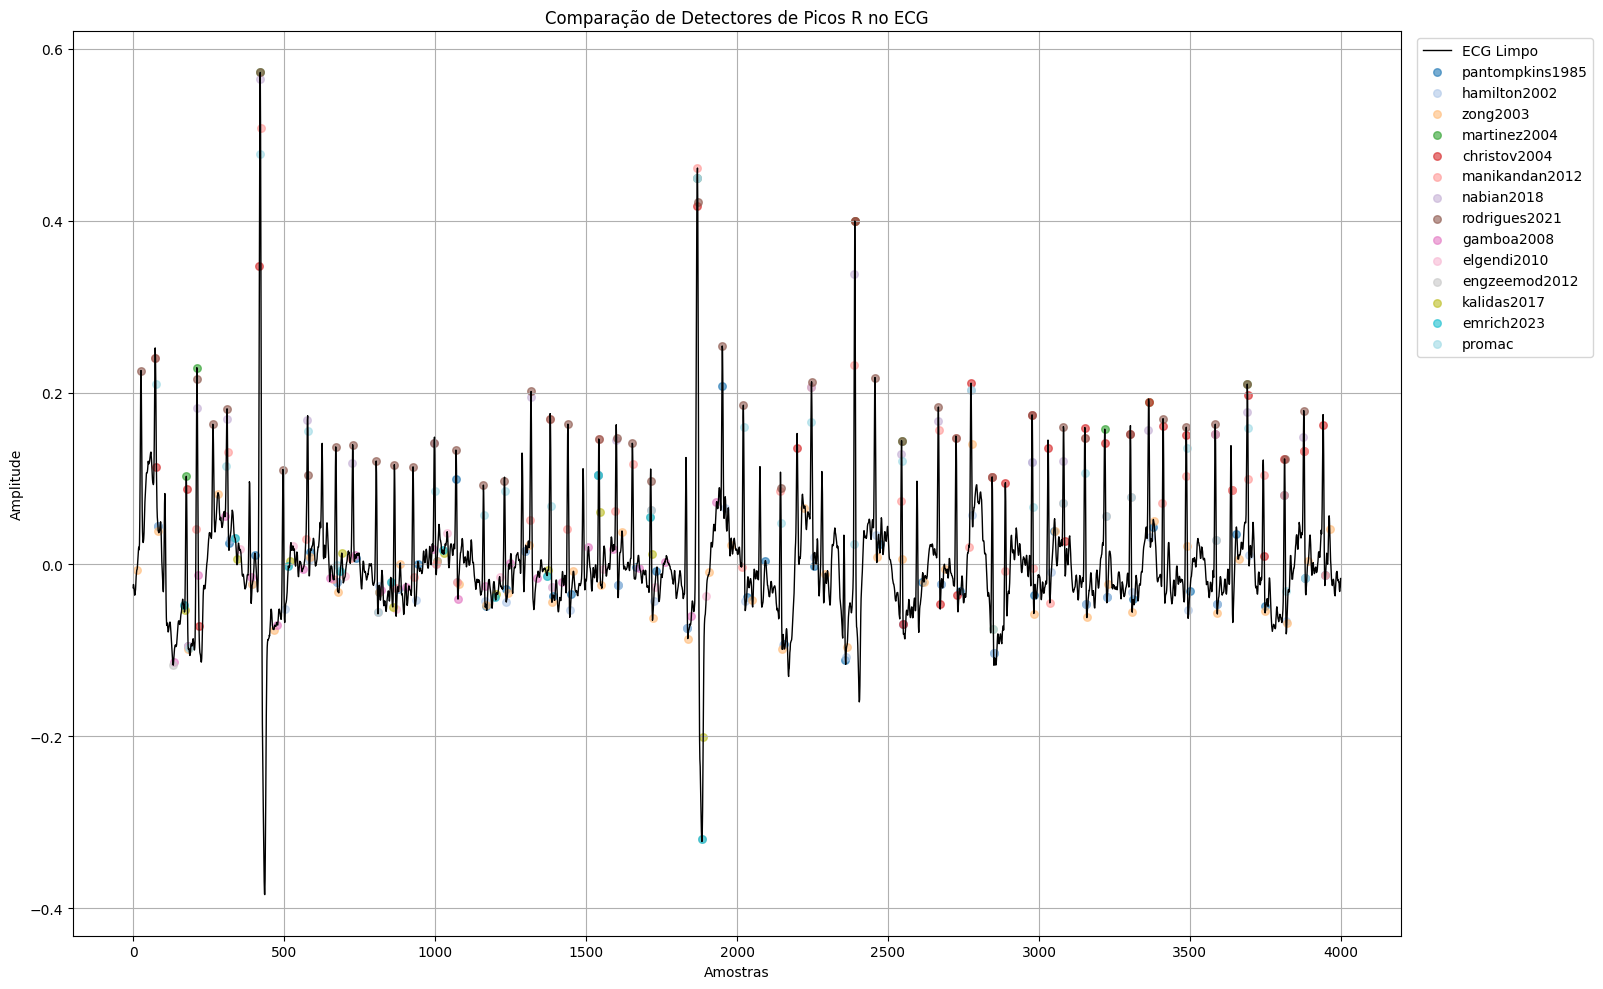

In [39]:
import neurokit2 as nk
import matplotlib.pyplot as plt
import numpy as np


sampling_rate = 200

amostra =  amostra_x.copy()

# Sinal limpo padrão
signals, _ = nk.ecg_process(amostra, sampling_rate=sampling_rate)
ecg_clean = signals["ECG_Clean"]

# Detectores simples (usam filtro padrão)
detectores_simples = [
    "pantompkins1985", "hamilton2002", "zong2003", "martinez2004",
    "christov2004", "manikandan2012", "nabian2018", "rodrigues2021"
]

# Detectores com filtro próprio
detectores_custom = [
    "gamboa2008", "elgendi2010", "engzeemod2012", "kalidas2017", "emrich2023"
]

# Inclui o promac
todos_metodos = detectores_simples + detectores_custom + ["promac"]

# Dicionário para armazenar os R-peaks
rpeaks_dict = {}

# Processando detectores simples
for metodo in detectores_simples:
    try:
        _, resultado = nk.ecg_peaks(ecg_clean, sampling_rate=sampling_rate, method=metodo)
        rpeaks_dict[metodo] = resultado["ECG_R_Peaks"]
    except Exception as e:
        print(f"Erro com {metodo}: {e}")

# Processando detectores com filtro próprio
for metodo in detectores_custom:
    try:
        ecg_filtrado = nk.ecg_clean(ecg, sampling_rate=sampling_rate, method=metodo)
        _, resultado = nk.ecg_peaks(ecg_filtrado, sampling_rate=sampling_rate, method=metodo)
        rpeaks_dict[metodo] = resultado["ECG_R_Peaks"]
    except Exception as e:
        print(f"Erro com {metodo}: {e}")

# Processando o ProMAC (combinado)
try:
    _, resultado_promac = nk.ecg_peaks(ecg_clean, sampling_rate=sampling_rate, method="promac")
    rpeaks_dict["promac"] = resultado_promac["ECG_R_Peaks"]
except Exception as e:
    print(f"Erro com promac: {e}")

# Gráfico de comparação
plt.figure(figsize=(16, 10))
plt.plot(ecg_clean, label="ECG Limpo", color="black", linewidth=1)

# Mostrar os picos detectados
colors = plt.cm.tab20(np.linspace(0, 1, len(todos_metodos)))
for i, metodo in enumerate(todos_metodos):
    if metodo in rpeaks_dict:
        rpeaks = rpeaks_dict[metodo]
        plt.scatter(rpeaks, ecg_clean[rpeaks], label=metodo, s=30, alpha=0.6, color=colors[i])

plt.title("Comparação de Detectores de Picos R no ECG")
plt.xlabel("Amostras")
plt.ylabel("Amplitude")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.grid(True)
plt.show()


In [16]:
# metodos = [
#     "pantompkins1985",
#     "hamilton2002",
#     "zong2003",
#     "martinez2004",
#     "christov2004",
#     "gamboa2008",
#     "elgendi2010",
#     "engzeemod2012",
#     "manikandan2012",
#     "kalidas2017",
#     "nabian2018",
#     "rodrigues2021",
#     "emrich2023",
#     "promac"
# ]

# import neurokit2 as nk

# # Limpeza do sinal base
# ecg_clean = nk.ecg_clean(ecg, sampling_rate=200)

# # Lista de métodos
# metodos = [
#     "pantompkins1985", "hamilton2002", "zong2003", "martinez2004",
#     "christov2004", "gamboa2008", "elgendi2010", "engzeemod2012",
#     "manikandan2012", "kalidas2017", "nabian2018", "rodrigues2021",
#     "emrich2023", "promac"
# ]

# # Dicionário para armazenar os resultados
# rpeaks_dict = {}

# for metodo in metodos:
#     try:
#         # Alguns métodos funcionam melhor com o sinal limpo
#         if metodo in ["gamboa2008", "elgendi2010", "engzeemod2012", "kalidas2017", "emrich2023"]:
#             sinal = nk.ecg_clean(ecg, sampling_rate=200, method=metodo)
#         else:
#             sinal = ecg
        
#         _, resultado = nk.ecg_peaks(sinal, sampling_rate=200, method=metodo)
#         rpeaks_dict[metodo] = resultado["ECG_R_Peaks"]
    
#     except Exception as e:
#         print(f"Erro com o método '{metodo}': {e}")


C:\Users\NOTEBOOK\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\NOTEBOOK\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


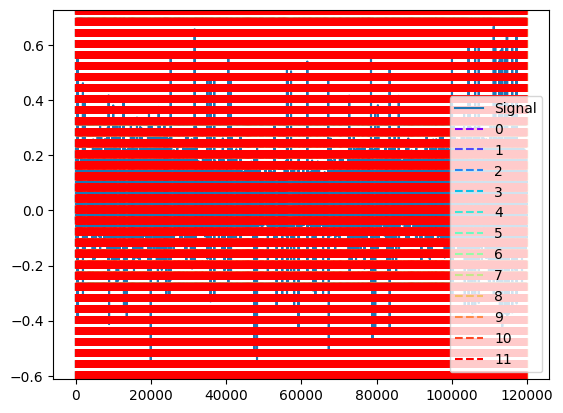

In [27]:

# Visualize results
nk.events_plot(rpeaks, ecg)

In [28]:
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np


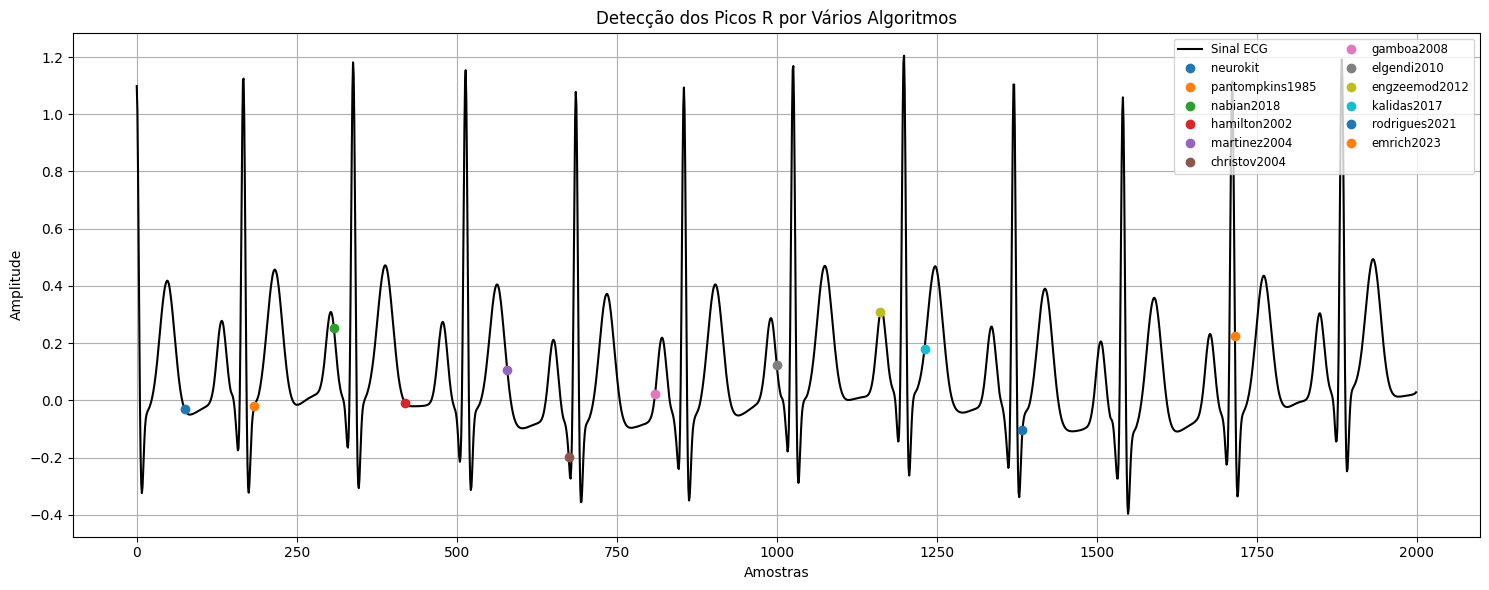

In [40]:
# Lista com os nomes dos métodos (na mesma ordem que os rpeaks)
nomes_metodos = [
    "neurokit", "pantompkins1985", "nabian2018", "hamilton2002",
    "martinez2004", "christov2004", "gamboa2008", "elgendi2010",
    "engzeemod2012", "kalidas2017", "rodrigues2021", "emrich2023"
]

# -------- GRÁFICO 1: TODOS OS PONTOS EM UM GRÁFICO -------- #
plt.figure(figsize=(15, 6))
plt.plot(ecg, label="Sinal ECG", color='black')

# Plota cada conjunto de picos R
for rpeaks_list, nome in zip(rpeaks, nomes_metodos):
    plt.plot(rpeaks_list, ecg[rpeaks_list], marker='o', linestyle='', label=nome)

plt.title("Detecção dos Picos R por Vários Algoritmos")
plt.xlabel("Amostras")
plt.ylabel("Amplitude")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


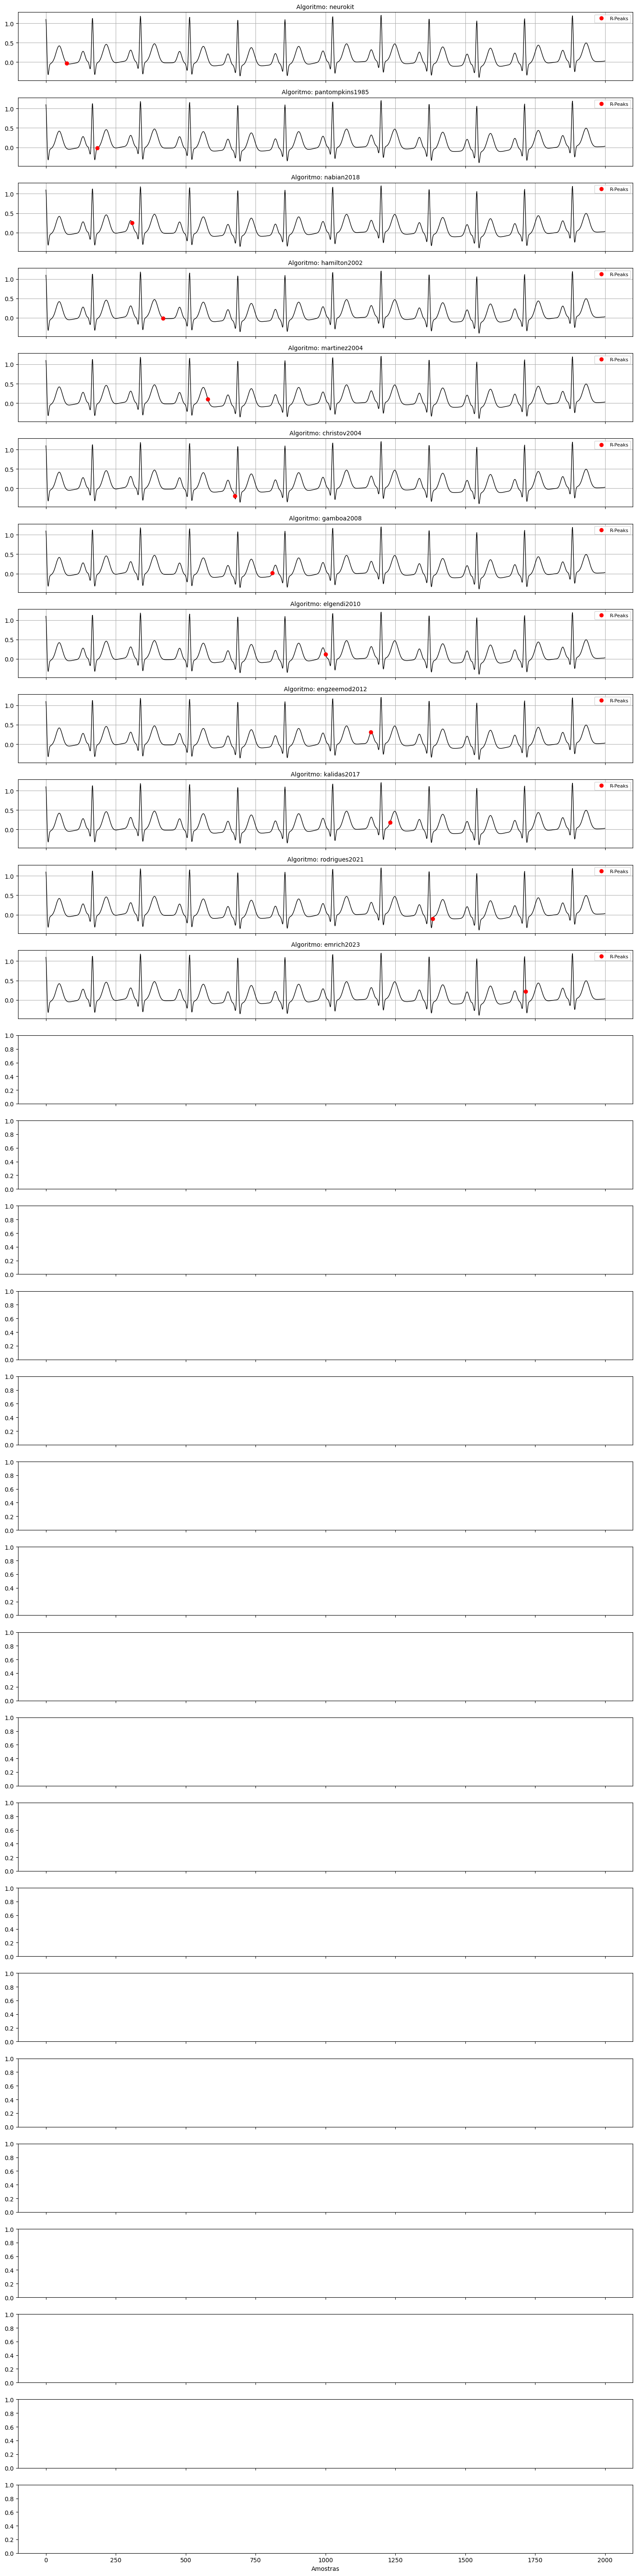

In [41]:
# -------- GRÁFICO 2: SUBPLOTS -------- #
fig, axs = plt.subplots(len(rpeaks), 1, figsize=(15, 2 * len(rpeaks)), sharex=True)

for i, (rpeaks_list, nome) in enumerate(zip(rpeaks, nomes_metodos)):
    axs[i].plot(ecg, color='black', linewidth=1)
    axs[i].plot(rpeaks_list, ecg[rpeaks_list], 'ro', label="R-Peaks")
    axs[i].set_title(f"Algoritmo: {nome}", fontsize=10)
    axs[i].grid(True)
    axs[i].legend(loc='upper right', fontsize=8)

axs[-1].set_xlabel("Amostras")
plt.tight_layout()
plt.show()


In [42]:
for nome, r in zip(nomes_metodos, rpeaks):
    print(f"{nome}: {len(r)} picos detectados")


TypeError: object of type 'numpy.int64' has no len()

In [32]:
referencia = rpeaks[0]  # exemplo: neurokit
for nome, r in zip(nomes_metodos[1:], rpeaks[1:]):
    diff = np.abs(np.array(r[:len(referencia)]) - np.array(referencia[:len(r)]))
    print(f"{nome} | Média da diferença com neurokit: {np.mean(diff):.2f} amostras")


pantompkins1985 | Média da diferença com neurokit: 8197.65 amostras
nabian2018 | Média da diferença com neurokit: 22382.93 amostras
hamilton2002 | Média da diferença com neurokit: 4390.42 amostras
martinez2004 | Média da diferença com neurokit: 48698.51 amostras
christov2004 | Média da diferença com neurokit: 20950.76 amostras
gamboa2008 | Média da diferença com neurokit: 20029.22 amostras
elgendi2010 | Média da diferença com neurokit: 517.90 amostras
engzeemod2012 | Média da diferença com neurokit: 16049.94 amostras
kalidas2017 | Média da diferença com neurokit: 2126.78 amostras
rodrigues2021 | Média da diferença com neurokit: 2774.07 amostras
emrich2023 | Média da diferença com neurokit: 5061.55 amostras


In [15]:
medias = [
    10743.90,
    25255.04,
    7171.64,
    50042.49,
    26901.05,
    21372.23,
    723.72,
    20476.98,
    3879.58,
    6521.83,
    2180.54
]

media_geral = sum(medias) / len(medias)
print(f"Média geral das diferenças: {media_geral:.2f} amostras")


Média geral das diferenças: 15933.55 amostras
